In [1]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context="notebook", style="whitegrid", palette="dark")

# Machine learning libraries
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OrdinalEncoder

# Art Garfunkel's Favorite Books

The dataset I am using to day is [Art Garfunkels's Library](https://www.kaggle.com/datasets/chrico03/art-garfunkels-library). Art Garfunkel is an American singer best known for his hit act with Paul Simon - Simon & Garfunkel. Ever since the 1970s, he has been recording the books he collects and reads over the years on his website. I will be using the prepared dataset of his "[Library](https://www.artgarfunkel.com/)" to try and predict which of the 1000+ books in his library are likely to be his favorite.

In [2]:
library_df = pd.read_csv("/kaggle/input/art-garfunkels-library/Art Garfunkel Library.csv")
library_df.head()

,Date Read,Author,Books,Year Published,Pages,Favorite
0,Jun-68,Jean-Jacques Rousseau,The Confessions,1781,606,1
1,Jun-68,Erich Fromm,The Art of Loving,1956,146,1
2,Jun-68,Mark Twain,The Adventures of Huckleberry Finn,1884,288,0
3,Jul-68,James Thurber,My Life and Hard Times,1933,115,0
4,Jul-68,William Shakespeare,Romeo and Juliet,1596,146,0


## Data Exploration & Cleaning
First, I will get the data into a format which I find more usable for my purposes.
- The 'Date Read' column can be broken up into two separate columns - 'Month Read' and 'Year Read'.
- The 'Year Published" column has a wide range of dates, some of which may be difficult to process (ie. "10,000 B.C."). Python is not great at handling these kinds of dates well, even using the datetime module. You can read more about it [here](https://realpython.com/lessons/messy-date-time/#transcript). So I will be removing these 45 rows.


In [3]:
months = dict(Jan=1,Feb=2,Mar=3,Apr=4,May=5,Jun=6,Jul=7,Aug=8,Sep=9,Oct=10,Nov=11,Dec=12)

def get_month_from_date_read_column(date, to_numeric=True):
    month_date_split = date.split('-')
    
    if len(month_date_split) == 2:
        if to_numeric == True:
            return int(months[month_date_split[0]])
        else:
            return month_date_split[0]
    else:
        return np.nan


def get_year_from_date_read_column(date):
    year_date_split = date.split('-')
    if len(year_date_split) == 2:
        year = int(year_date_split[1])
        if year < 41: # FUN FACT: Art's Year of Birth: 1941
            return int(2000+year)
        else :
            return int(1900+year)
    else:
        return np.nan    

In [4]:
library_df['Month Read'] = library_df['Date Read'].apply(lambda date: get_month_from_date_read_column(date))
library_df['Cat_Month Read'] = library_df['Date Read'].apply(lambda date: get_month_from_date_read_column(date,False))
  
library_df['Year Read'] = library_df['Date Read'].apply(lambda date: get_year_from_date_read_column(date))
library_df['Decade Read'] = library_df['Year Read'].apply(lambda y: np.floor(y/10)*10)

In [5]:
library_df['Year Published'] = library_df['Year Published'].apply(lambda year: np.nan if (len(year) != 4 or str(year[-1]).isalpha()) else year)

# Encoding cyclical features (hour, month, year, etc.)
library_df['cos_Month Read'] = np.sin(2 * np.pi * library_df['Month Read']/12.0)
library_df['sin_Month Read'] = np.sin(2 * np.pi * library_df['Month Read']/12.0)

In [6]:
def get_author_count(authors):
    authors = authors.split(',')
    skips = [' M.D.', ' Jr.', 'editor', ' ed.' ]
    for author in authors:
        if author in skips:
            authors.remove(author)
    return len(authors)

def get_single_author(author):
    if author == 'Various':
        return np.nan
    return 1

In [7]:
library_df['Words in Title'] = library_df.Books.apply(lambda b: len(b.split()))

library_df['Surname Length'] = library_df.Author.apply(lambda a: len(a.split()[-1].replace('-', '')))
library_df['Author Count'] = library_df.Author.apply(lambda a: get_single_author(a) if len(a.split(','))==1 else get_author_count(a)).sort_values()

## Exploratory Analysis
Now we can look at the data to determine which features can be used for the analysis. I decided not to use 'Author' or 'Books' because of thier high number of unique entries relative to the total size of the dataset. The other columns can be encoded as labels that have more significant relevance to the rest of items in it.

In [8]:
library_df.drop(columns=['cos_Month Read', 'sin_Month Read']).describe(percentiles=[])

,Pages,Favorite,Month Read,Year Read,Decade Read,Words in Title,Surname Length,Author Count
count,1321.000000,1321.000000,1196.000000,1196.000000,1196.000000,1321.000000,1321.000000,1314.000000
mean,313.020439,0.102952,6.745819,1993.517559,1989.046823,3.669190,6.582135,1.029680
std,191.174830,0.304012,3.471429,13.164890,13.645646,2.078832,1.826849,0.220507
min,13.000000,0.000000,1.000000,1968.000000,1960.000000,1.000000,2.000000,1.000000
50%,275.000000,0.000000,7.000000,1992.000000,1990.000000,3.000000,6.000000,1.000000
max,1664.000000,1.000000,12.000000,2022.000000,2020.000000,15.000000,14.000000,4.000000


Here, we can look at the target feature. The target column for this dataset is 'Favorite'; there's a big imbalance between the number of non-favorite vs. favorite books, which affects how we will approach our analysis.

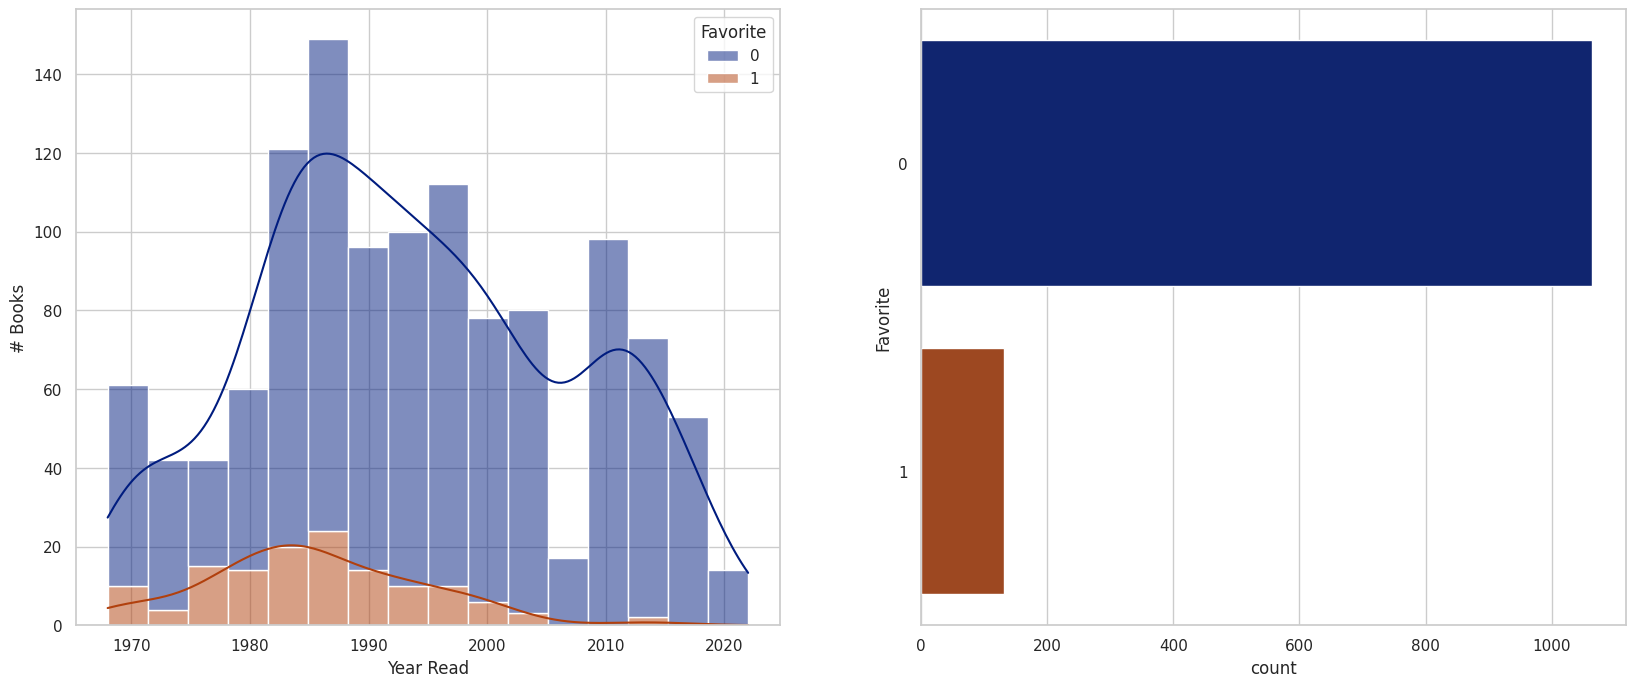

In [9]:
books_per_year = library_df._get_numeric_data().groupby('Year Read').count()['Pages'].reset_index()
books_per_year = books_per_year.rename({'Pages':'Books Per Year'}, axis=1)
library_df = library_df.merge(books_per_year, on='Year Read')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
ax1.set_xlabel("Year Read")
ax1.set_ylabel("# Books")

sns.histplot(data=library_df, x="Year Read", hue='Favorite', kde=True, multiple='stack', ax=ax1)
sns.countplot(y=library_df['Favorite'],data=library_df, ax=ax2)
plt.show()

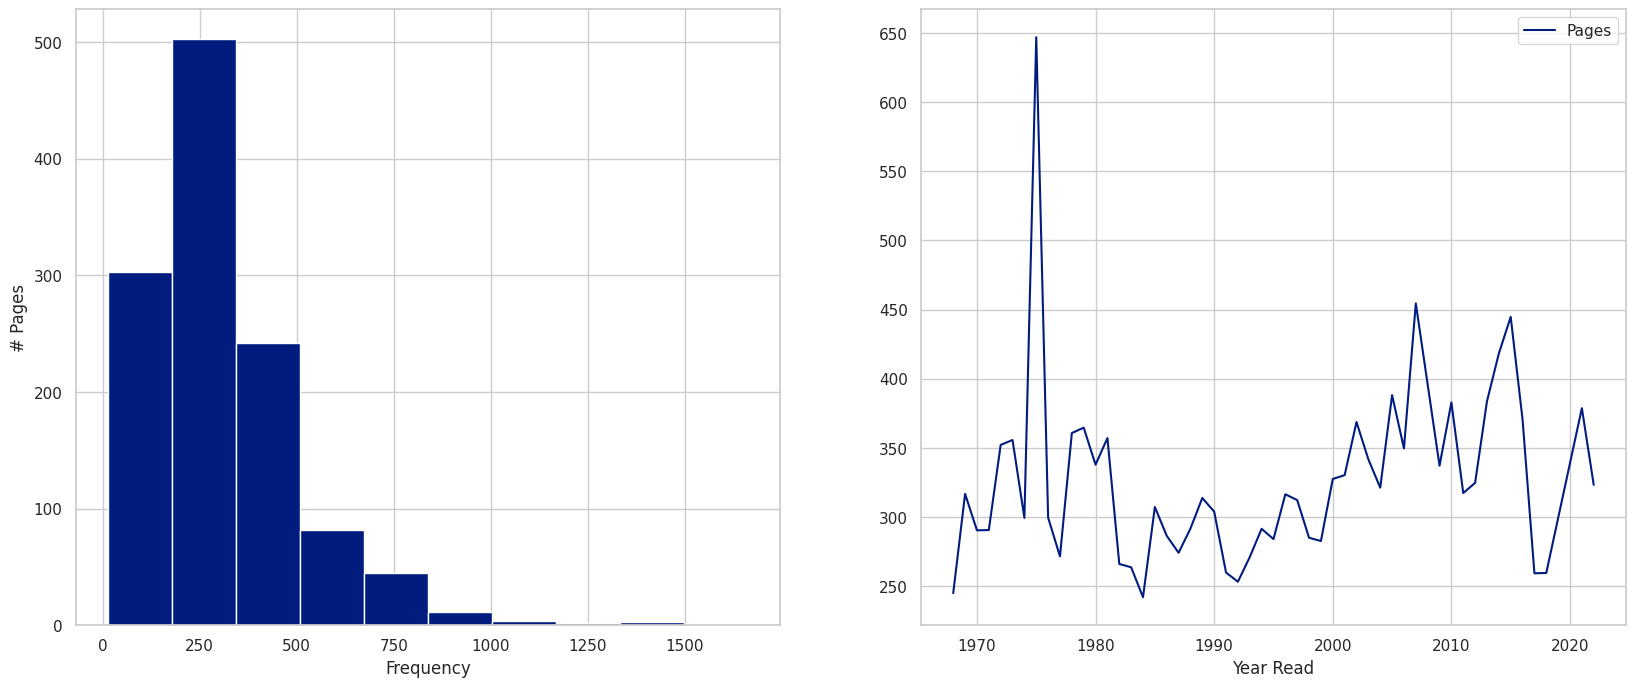

In [10]:
pages_per_year = library_df[['Year Read', 'Pages']].groupby(['Year Read']).mean()
library_df = library_df.merge(pages_per_year, on='Year Read', suffixes=['', ' Per Year'])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
ax1.set_xlabel("Frequency")
ax1.set_ylabel("# Pages")

library_df['Pages'].hist(ax=ax1)
sns.lineplot(pages_per_year, ax=ax2)
plt.show()

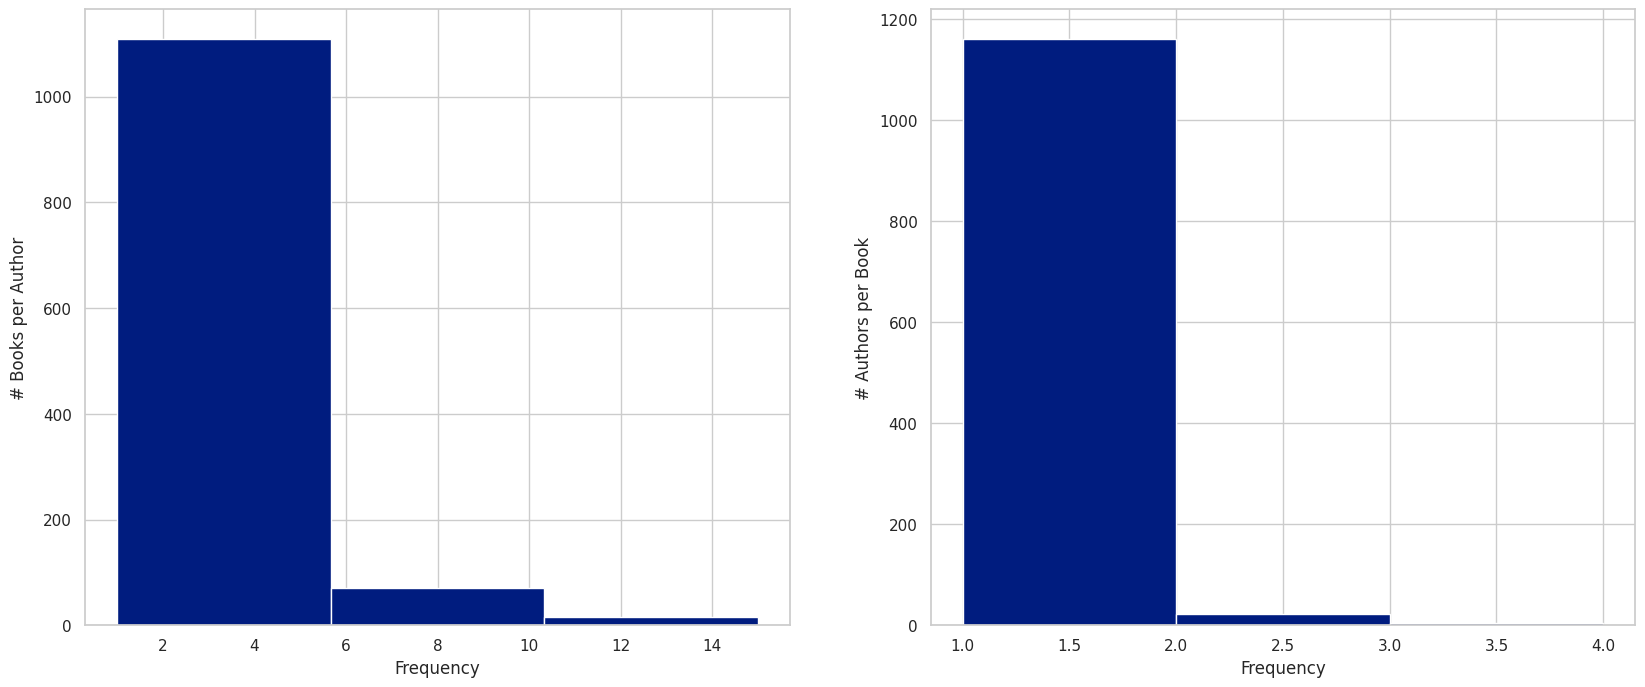

In [11]:
books_per_author = library_df.groupby(['Author']).count()['Books'].reset_index()
library_df = library_df.merge(books_per_author, on='Author', suffixes=['', ' Per Author'])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
ax1.set_xlabel("Frequency")
ax2.set_xlabel("Frequency")
ax1.set_ylabel("# Books per Author")
ax2.set_ylabel("# Authors per Book")

library_df['Books Per Author'].hist(ax=ax1, bins=3)
library_df['Author Count'].hist(ax=ax2, bins=3)
plt.show()

In [12]:
print("Final shape of data:", library_df.shape)
print("\nFeatures: \n", library_df.columns.values)

Final shape of data: (1196, 18)

Features: 
 ['Date Read' 'Author' 'Books' 'Year Published' 'Pages' 'Favorite'
 'Month Read' 'Cat_Month Read' 'Year Read' 'Decade Read' 'cos_Month Read'
 'sin_Month Read' 'Words in Title' 'Surname Length' 'Author Count'
 'Books Per Year' 'Pages Per Year' 'Books Per Author']


* I will use RobustScaler for the data as there are a few outliers across the columns found during data exploration.
* 'Month Read' will also be encoded cyclically so the seuqential nature of the month category will be taken into account within the model.
* We have a lot of 'nan' values, instead of removing them, I will use an imputer to fill in values.

## Model Creation & Evaluation

In [13]:
library_df = library_df.drop(columns=['Date Read', 'Books', 'Author', 'Cat_Month Read', 'Month Read'])

# Imputing missing values for 'Month Read', 'Year Published', 'Various'
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
library_df = pd.DataFrame(imputer.fit_transform(library_df), columns=library_df.columns)
library_df.head()

,Year Published,Pages,Favorite,Year Read,Decade Read,cos_Month Read,sin_Month Read,Words in Title,Surname Length,Author Count,Books Per Year,Pages Per Year,Books Per Author
0,1781.0,606.0,1.0,1968.0,1960.0,1.224647e-16,1.224647e-16,2.0,8.0,1.0,12.0,244.916667,8.0
1,1781.0,122.0,0.0,1980.0,1980.0,-5.000000e-01,-5.000000e-01,6.0,8.0,1.0,12.0,337.833333,8.0
2,1781.0,606.0,0.0,1983.0,1980.0,5.000000e-01,5.000000e-01,2.0,8.0,1.0,36.0,263.611111,8.0
3,1762.0,226.0,0.0,1983.0,1980.0,-5.000000e-01,-5.000000e-01,4.0,8.0,1.0,36.0,263.611111,8.0
4,1762.0,226.0,0.0,1983.0,1980.0,-5.000000e-01,-5.000000e-01,10.0,8.0,1.0,36.0,263.611111,8.0


In [14]:
transformer = make_column_transformer(
    (RobustScaler(), ['Pages', 'Pages Per Year', 
                      'Books Per Year', 'Books Per Author', 
                      'Words in Title', 'Surname Length', 'Author Count']),
    (OrdinalEncoder(), ['Year Read', 'Year Published', 'Decade Read']),
    remainder="passthrough", sparse_threshold=0)

transformed = transformer.fit_transform(library_df)
feature_names = [name.split("__")[-1] for name in transformer.get_feature_names_out()]

transformed_df = pd.DataFrame(transformed, columns=feature_names)
print("Train data shape: ", transformed_df.shape)

Train data shape:  (1196, 13)


Since our classes are imbalanced, accuracy may not be the best performance metric. So, instead, we will be using the F-1 score as our evaluation metric, which allows us to produce more reliable results for an imbalanced dataset such as this.

In [15]:
x = transformed_df.drop(columns=['Favorite'])
y = transformed_df['Favorite'].astype('int')

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25, stratify=y)

print("x_train shape: " + str(x_train.shape))
print("x_test shape: " + str(x_test.shape))

x_train shape: (897, 12)
x_test shape: (299, 12)


In [16]:
clf = LogisticRegressionCV(multi_class='ovr', class_weight='balanced', scoring='f1')
clf.fit(x_train,y_train)

y_pred = clf.predict(x_test)
print("\nClassification Report\n",classification_report(y_test, y_pred))
print("Confusion Matrix\n", confusion_matrix(y_test,y_pred))


Classification Report
               precision    recall  f1-score   support

           0       0.95      0.74      0.83       266
           1       0.24      0.67      0.35        33

    accuracy                           0.73       299
   macro avg       0.59      0.70      0.59       299
weighted avg       0.87      0.73      0.78       299

Confusion Matrix
 [[196  70]
 [ 11  22]]


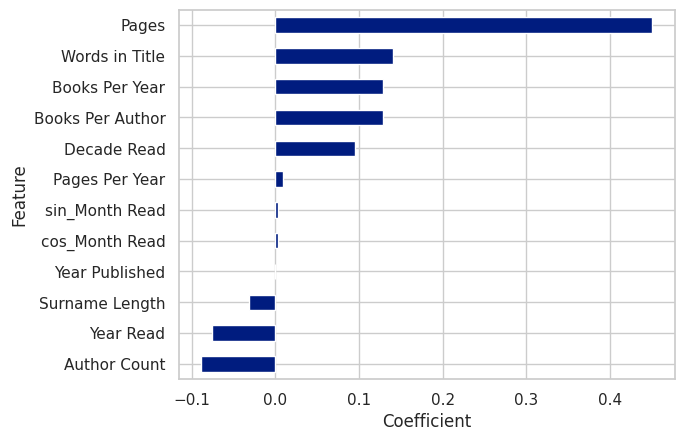

In [17]:
coefs = pd.Series(clf.coef_.ravel(), index=clf.feature_names_in_)
coefs.sort_values().plot(kind='barh')

plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.show()

## Final Thoughts
When doing this analysis, I tested several models type, feature encodings and model parameters. Perhaps the results may improve with different options, I chose what I believed went best for the question I was trying to answer. So when I run the analysis again, both classes are predicted more often and our score has decreased, but with the more balanced classes, the estimate obtained here we know is using more data to predict both classes. The coefficients changed in number, but not relative to one another. 

Perhaps, in the future, I could improve my results if I:
* Find a way to increase the sample size - either by finding new ways to process dropped rows so they can remain within the dataset for the analysis
* Perform data scraping on Art Garfunkel's website to update the initial dataset to include any more recent entries.
* Encode the year and month data in different ways such as using binning to reduce dimensionality. For example, encoding 'Month Read' as categorical labels within bins I define as 3-month-long 'Seasons.'

